# Plots a 2d representation of factor similarity for the first $10^6$ integers

The idea comes from this [tweet](https://twitter.com/jhnhw/status/1031829726757900288). I just play around with it.

Thanks to John Williamson (@jhnhw)

## Calculate the factors with sympy

In [1]:
import sympy

In [2]:
factors = [sympy.factorint(x) for x in range(int(1e6))]

get all the primes needed to build integers up to $10^6$

In [3]:
primes = set()
for fac in factors:
    primes.update(fac.keys())

In [4]:
len(primes)

78499

## Build the matrix

In [5]:
# sort primes to use as index
primes = sorted(primes)

with a dense matrix we will need aprox:

In [40]:
print(f'~{(len(primes) * 1e6) / 1e9:.3} Gb')

~78.5 Gb


not today!

Go for sparse matrix:

In [7]:
from scipy import sparse
from tqdm import tqdm_notebook
tqdm = tqdm_notebook

In [44]:
try:
    mat = sparse.load_npz('1e6_factors_mat.npz')
    print('sparse matrix loaded from disk')

except FileNotFoundError:
    print('building sparse matrix from scratch...')
    
    mat = sparse.lil_matrix((int(1e6), len(primes)), dtype=int)
    
    # populate the sparse matrix
    for i, fac in tqdm(enumerate(factors)):
        for key, value in fac.items():
            # find index of prime in colum
            col = primes.index(key)
            # insert value (exponent) in position.
            # should I put 1?
            mat[i, col] = value
    
    mat_csr = mat.tocsr()
    
    print(f'matrix size: {mat.data.nbytes/1e6:.3} Mb')
    
    # save to disk
    sparse.save_npz('1e6_factors_mat.npz', mat_csr)

sparse matrix loaded from disk


### UMAP dimensionality reduction

In [13]:
import umap

In [15]:
reducer = umap.UMAP(metric='cosine', verbose=2, n_epochs=500)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='cosine',
   metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=500,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=2)


In [16]:
# takes about 2 hours with an i7 7700 ;_;7
embedding = reducer.fit_transform(mat_csr)

Construct fuzzy simplicial set
	 0  /  20
	 1  /  20
	 2  /  20
	 3  /  20
	 4  /  20
	 5  /  20
	 6  /  20
	 7  /  20
	 8  /  20
	 9  /  20
	 10  /  20
	 11  /  20
	 12  /  20
	 13  /  20
	 14  /  20
	 15  /  20
	 16  /  20
	 17  /  20
	 18  /  20
	 19  /  20
Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs


In [45]:
np.save('embedding_primes', embedding)

## Draw

In [38]:
import matplotlib.pyplot as plt
import matplotlib as mp

import numpy as np
import pandas as pd

import datashader as ds
import datashader.utils as utils
import datashader.transfer_functions as tf

In [46]:
mat = np.load('embedding_primes.npy')

In [47]:
df = pd.DataFrame(mat, columns=['x', 'y'])

C:\Users\Biel\Anaconda3\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


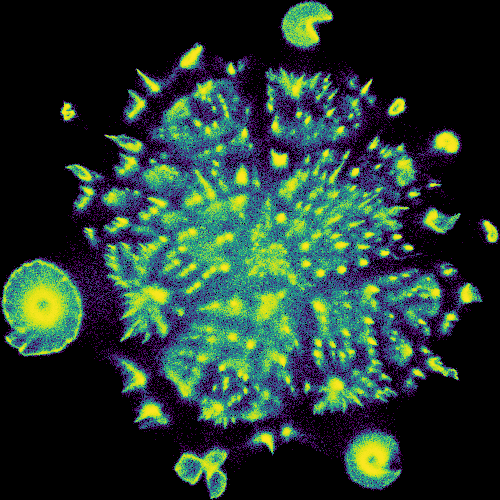

In [52]:
cvs = ds.Canvas(plot_width=500, plot_height=500)
agg = cvs.points(df, 'x', 'y')
img = tf.shade(agg, how='eq_hist', cmap=mp.cm.viridis)
tf.set_background(img, 'black')

### color by integer value

(-6.199255054142312, 4.813847129490213, -5.659213587060581, 5.58000092150272)

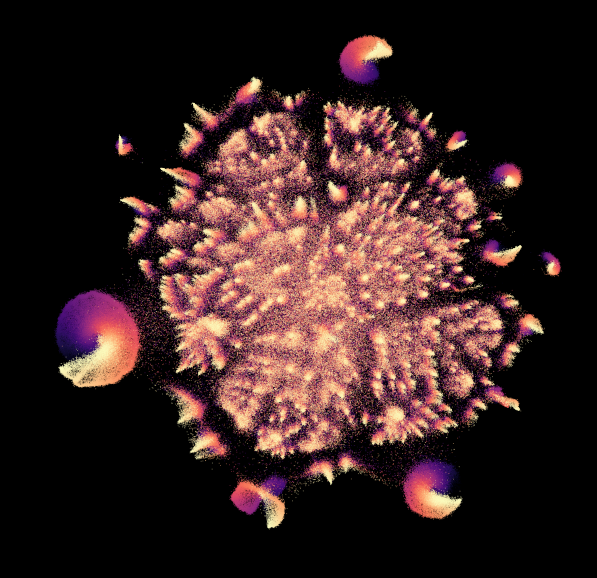

In [54]:
fig = plt.figure(figsize=(10,10))
fig.patch.set_facecolor('black')
plt.scatter(df.x, df.y, marker='o', s=1, edgecolor='',
            c=df.index, cmap="magma", alpha=0.5)

plt.axis("off")